True flux = 122440.03


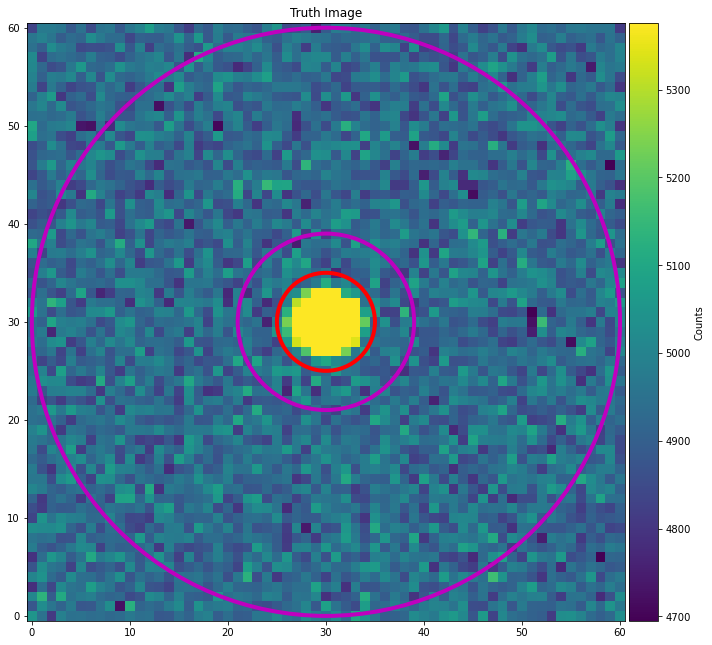

In [246]:
import numpy as np 
import matplotlib.pyplot as plt 
from astropy.modeling import models, fitting
from astropy.visualization import ImageNormalize, ZScaleInterval, MinMaxInterval
from mpl_toolkits.axes_grid1 import make_axes_locatable
from photutils import CircularAperture, CircularAnnulus, aperture_photometry
from scipy.stats import sigmaclip
from matplotlib.patches import Circle

#Create cutout
box_size = 61
gain = 8.21
xx, yy = np.meshgrid(np.arange(box_size), np.arange(box_size))
zz = np.zeros(np.shape(xx))
zz += np.random.poisson(4780, np.shape(zz)) #Simulate background
zz += np.random.normal(19*8.21) #Simulate read/dark current

#Add star 
star = models.Gaussian2D(amplitude=10000., x_mean=int(box_size/2), y_mean=int(box_size/2), x_stddev=1.5, y_stddev=1.3)
star_model = star(xx,yy)
zz += star_model

#Define aperture and annulus
ap_r = 5
an_in = 9
an_out = 30
ap = CircularAperture((int(box_size/2), int(box_size/2)), r=ap_r)
an = CircularAnnulus((int(box_size/2), int(box_size/2)), r_in=an_in, r_out=an_out)

#Perform photometry on the "truth" image. 
true_phot = aperture_photometry(zz, ap)

bg_mask = an.to_mask(method='exact')
bg_annulus = bg_mask.multiply(zz)
bg_1d = bg_annulus[bg_annulus != 0]
bg_vals = sigmaclip(bg_1d)[0]
bg = np.median(bg_vals)

true_flux = true_phot['aperture_sum'][0] - bg*ap.area
print('True flux = {:8.2f}'.format(true_flux))

#Plot the "truth" image with aperture/annulus. 
fig, ax = plt.subplots(1,1,figsize=(12,11))
norm = ImageNormalize(zz, interval=ZScaleInterval())
im = ax.imshow(zz, origin='lower', norm=norm)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical', label='Counts')
ax.set_title('Truth Image')

ap_plot = Circle((int(box_size/2),int(box_size/2)), ap_r, color='r', fill=False, lw=4)
ax.add_patch(ap_plot)

an_in_plot = Circle((int(box_size/2),int(box_size/2)), an_in, color='m', fill=False, lw=4)
ax.add_patch(an_in_plot)

an_out_plot = Circle((int(box_size/2),int(box_size/2)), an_out, color='m', fill=False, lw=4)
ax.add_patch(an_out_plot)


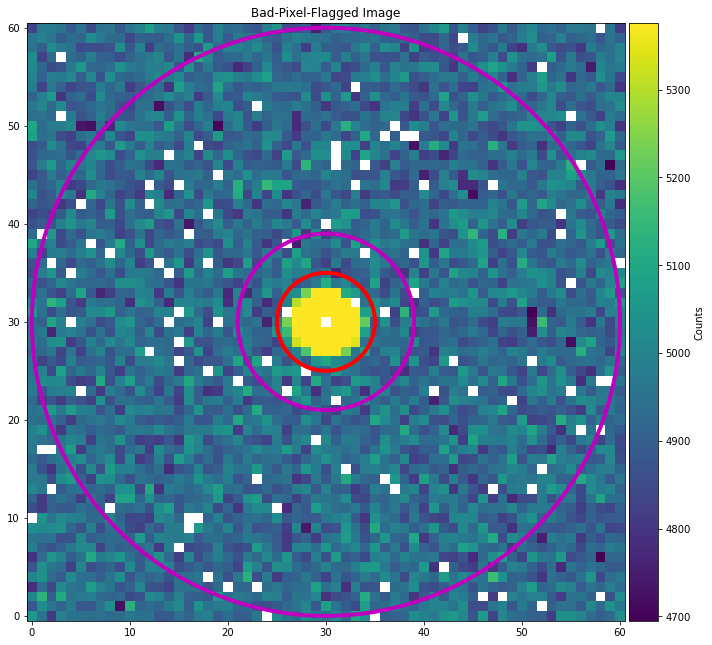

In [247]:
#Make the central pixel a NaN. 
zz[int(box_size/2), int(box_size/2)] = np.nan

#Expect ~3% of pixels to be bad.
n_other_bad = int((0.028*box_size**2)) - 1

other_bad_locs = np.random.choice(np.arange(box_size), (n_other_bad, 2))
for i in range(n_other_bad):
    bl = other_bad_locs[i]
    zz[bl[0], bl[1]] = np.nan
    
#Plot the "bad pixel" image
fig, ax = plt.subplots(1,1,figsize=(12,11))
im = ax.imshow(zz, origin='lower', norm=norm)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical', label='Counts')
ax.set_title('Bad-Pixel-Flagged Image')

ap_plot = Circle((int(box_size/2),int(box_size/2)), ap_r, color='r', fill=False, lw=4)
ax.add_patch(ap_plot)

an_in_plot = Circle((int(box_size/2),int(box_size/2)), an_in, color='m', fill=False, lw=4)
ax.add_patch(an_in_plot)

an_out_plot = Circle((int(box_size/2),int(box_size/2)), an_out, color='m', fill=False, lw=4)
ax.add_patch(an_out_plot)

In [248]:
#Try to recover it with a 2D Gaussian fit. 
model_init = models.Const2D(amplitude=np.nanmean(zz)) + models.Gaussian2D(amplitude=np.nanmax(zz), x_mean=int(box_size/2), y_mean=int(box_size/2), x_stddev=1.4, y_stddev=1.4)

mask = ~np.isnan(zz) #Find locations where the cutout has *good* values (i.e. not NaNs). 
x = xx[mask] #Only use coordinates at these good values.
y = yy[mask]
cutout_1d = zz[mask] #Make a 1D cutout using only the good values. 
fitter = fitting.LevMarLSQFitter()
model_fit = fitter(model_init, x, y, cutout_1d) #Fit the model to the 1d cutout.
zz[~mask] = model_fit(xx,yy)[~mask]
                        
interpolated_phot = aperture_photometry(zz, ap)

model_fit.parameters
interpolated_phot

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,30.0,30.0,509717.368428634


In [249]:
bg_mask = an.to_mask(method='exact')
bg_annulus = bg_mask.multiply(zz)
bg_1d = bg_annulus[bg_annulus != 0]
bg_vals = sigmaclip(bg_1d)[0]
bg = np.median(bg_vals)


In [250]:
interpolated_flux = interpolated_phot['aperture_sum'][0] - ap.area*bg
print(true_flux)
print(interpolated_flux)


122440.02553622337
122023.54370894667


In [251]:
print(truth / interp)

   aperture_sum   
------------------
1.0007994999003929
